<a href="https://colab.research.google.com/github/sachinmkotian/CloudxLabs_sachin_2024/blob/main/Sachin_Assignment_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# Sentiment analysis using Tensor Flow Supervised Learning
# Project by Sachin Kotian for CloudxLabs
# Date 27-Dec-2024

#import all required Tensorflow libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

#Use pandas read function to read the csv file. Add columns names as there are none

df = pd.read_csv("/content/amazon_review_small.txt",names=["Rating", "Summary", "Review"])
df.head()

,Rating,Summary,Review
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


In [83]:
#drop Summary column as not required
df= df.drop(columns=['Summary'])
df.head()

,Rating,Review
0,1,"This model may be ok for sedentary types, but ..."
1,4,This is a fast read filled with unexpected hum...
2,2,I bought one of these chargers..the instructio...
3,2,I was excited to find a book ostensibly about ...
4,2,"I am a big JVC fan, but I do not like this mod..."


In [91]:
#Some data clean up
#Need to remove rows that don't have values
df = df.dropna(subset=["Rating","Review"])
#Remove leading and trailing spaces
df['Review'] = df['Review'].str.strip()
df.head()

,Rating,Review
0,1,"This model may be ok for sedentary types, but ..."
1,4,This is a fast read filled with unexpected hum...
2,2,I bought one of these chargers..the instructio...
3,2,I was excited to find a book ostensibly about ...
4,2,"I am a big JVC fan, but I do not like this mod..."


In [92]:
#Making Rating Postive and negative ratings...i.e. if rating >= 3 its positive else negative.
df["Label"] = (df.Rating >= 3).astype(int)
df = df[["Rating","Review","Label"]]
df.head()

,Rating,Review,Label
0,1,"This model may be ok for sedentary types, but ...",0
1,4,This is a fast read filled with unexpected hum...,1
2,2,I bought one of these chargers..the instructio...,0
3,2,I was excited to find a book ostensibly about ...,0
4,2,"I am a big JVC fan, but I do not like this mod...",0


In [93]:
# Use this function to convert dataframe to Tensor dataset which is a multi-dimensional matrix containing elements of a single data type
def df_to_dataset(dataframe, shuffle=True, batch_size=5000):
    df = dataframe.copy()
    lables = df.pop('Label')
    df = df["Review"]
    ds = tf.data.Dataset.from_tensor_slices((df, lables))
    if shuffle:
      ds = ds.shuffle(buffer_size = len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [94]:
#create Tensor datasets out of train, test and validate data
train_data = df_to_dataset(train)
test_data = df_to_dataset(test)
validate_data = df_to_dataset(validate)

In [95]:
list(train_data)[0]

(<tf.Tensor: shape=(5000,), dtype=string, numpy=
 array([b'Ken Follett is one of the greatest writers of our time. "Eye of the Needle" is one of those books you can\'t put down and don\'t want to end.',
        b"For Phil Collins, he has today came a very, very long way since he started his path to solo stardom. Still, it was absolutely bittersweet from the very beginning. Phil was going through a painful divorce, when he wrote In The Air Tonight. Whatever it was, it became Phil's first Top 20 hit, and locked Phil Collins in as a force beyond Genesis. Although it was edited down here, and not the full-length version from Hits and Face Value, it still is just as haunting and surprising as you'd expect from Phil. Still, it is just a shame that people don't respect Phil Collins now, like they used to back in the 1980's. Still, you can't help but enjoy his music.",
        b'Video quality is acceptable ( B&W ) but sound track is barely audible at maximum volume on a std.def.DVD player. The

In [96]:
#Text embeddings based on feed-forward Neural-Net Language Models - English
#The module preprocesses its input by splitting on spaces and/or removing punctuation
#Token based text embedding trained on English Google News 7B corpus.

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer= hub.KerasLayer(embedding, dtype=tf.string,trainable=True)
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(5000, 50), dtype=float32, numpy=
array([[ 0.21944727,  0.12197533, -0.08084553, ..., -0.4039595 ,
         0.11977378,  0.17644653],
       [ 0.72023267,  0.37542403,  0.0837605 , ..., -0.35176858,
         0.09234338,  0.06373834],
       [ 0.16795431, -0.17643523,  0.01621685, ..., -0.16791497,
         0.22709468, -0.0912689 ],
       ...,
       [ 0.69928706, -0.27044168, -0.01314403, ...,  0.37308493,
         0.00589275,  0.39861855],
       [ 0.52564096,  0.44773906,  0.2642579 , ...,  0.09476815,
        -0.19143179,  0.06114459],
       [ 0.68277603,  0.08954281,  0.33298525, ..., -0.24342765,
        -0.17133781,  0.19068567]], dtype=float32)>

In [97]:
#Create a Keras Sequential model by passing a list of layers to the Sequential constructor

model = tf_keras.Sequential()
model.add(hub_layer)
model.add(tf_keras.layers.Dense(16,activation='relu'))
model.add(tf_keras.layers.Dropout(0.4))
model.add(tf_keras.layers.Dense(16,activation='relu'))
model.add(tf_keras.layers.Dropout(0.4))
model.add(tf_keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),loss=tf_keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

model.evaluate(train_data)
model.evaluate(validate_data)

13/13 [==============================] - 2s 138ms/step - loss: 0.6806 - accuracy: 0.5980


[0.6806254982948303, 0.5979846119880676]

In [98]:
#TensorFlow Supervised learning
history = model.fit(train_data,epochs=5,validation_data=validate_data)

Epoch 1/5
104/104 [==============================] - 164s 2s/step - loss: 0.6136 - accuracy: 0.6440 - val_loss: 0.4998 - val_accuracy: 0.7708
Epoch 2/5
104/104 [==============================] - 160s 2s/step - loss: 0.4869 - accuracy: 0.7742 - val_loss: 0.4380 - val_accuracy: 0.7949
Epoch 3/5
104/104 [==============================] - 160s 2s/step - loss: 0.4414 - accuracy: 0.8025 - val_loss: 0.4251 - val_accuracy: 0.7987
Epoch 4/5
104/104 [==============================] - 160s 2s/step - loss: 0.4172 - accuracy: 0.8154 - val_loss: 0.4237 - val_accuracy: 0.7999
Epoch 5/5
104/104 [==============================] - 160s 2s/step - loss: 0.3981 - accuracy: 0.8252 - val_loss: 0.4260 - val_accuracy: 0.7994


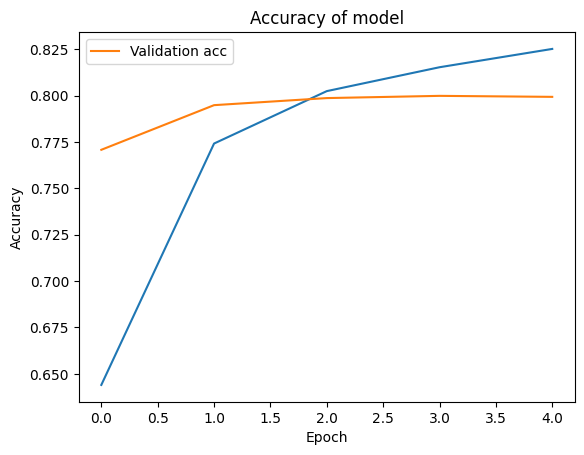

In [99]:
#Plotting Epoch wise accuracy of model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],label='Validation acc')
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [100]:
model.evaluate(test_data)

13/13 [==============================] - 3s 230ms/step - loss: 0.4256 - accuracy: 0.8005


[0.42562776803970337, 0.8004922866821289]

In [101]:
#Summary
#Model shows high accuracy on test data of 80%